### Extreme Value Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Select dataset (1 for 1973-2013, 2 for 2004-2013)
num = 1

# Set threshold for exceedance analysis (in ft)
thresh = 7.6

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')
df2 = pd.read_csv('Data_1973_2004.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

# Extract daily maximum wave heights
max_obs = df1['H'].resample('D').max()
max_pred = df2['H_pred'].resample('D').max()

if num == 1:
    SWH = pd.concat([max_pred, max_obs], axis=0)
elif num == 2:
    SWH = max_obs

# Exceedances
exceed = SWH[SWH > thresh] - thresh
exceed_rate = len(exceed) / len(SWH)
print(f'Exceedance rate = {exceed_rate:.4f} ({len(exceed)} exceedances over {len(SWH)} records)')

# Fit GPD to exceedances
xi, _, sigma = stats.genpareto.fit(exceed, floc=0)
print(f'GPD parameters: xi = {xi:.4f}, sigma = {sigma:.4f}')

Exceedance rate = 0.0062 (91 exceedances over 14610 records)
GPD parameters: xi = 0.2092, sigma = 0.9681


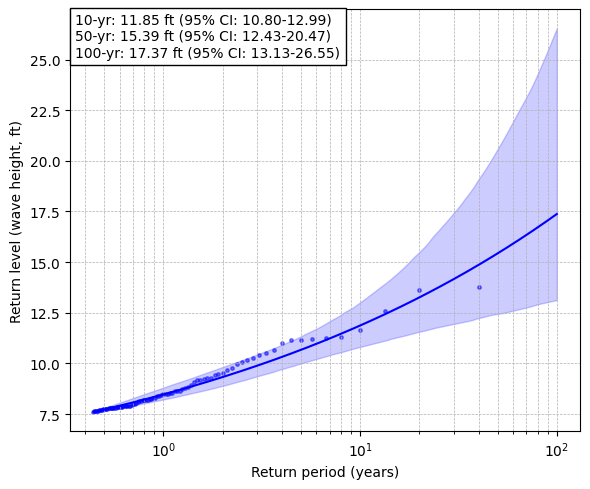

In [2]:
# Return periods (in days) and return levels
return_periods = np.logspace(np.log10(0.01), np.log10(100), 300) * 365
return_levels = thresh + (sigma / xi) * ((return_periods * exceed_rate) ** xi - 1)

# Bootstrap confidence intervals
n_bootstrap = 1000
bootstrap_levels = np.zeros((n_bootstrap, len(return_periods)))

for i in range(n_bootstrap):
    resampled = np.random.choice(exceed, size=len(exceed), replace=True)
    xi_b, _, sigma_b = stats.genpareto.fit(resampled, floc=0)
    try:
        rl_b = thresh + (sigma_b / xi_b) * ((return_periods * exceed_rate) ** xi_b - 1)
        bootstrap_levels[i, :] = rl_b
    except:
        bootstrap_levels[i, :] = np.nan

lower_bound = np.percentile(bootstrap_levels, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_levels, 97.5, axis=0)

# Return level plot
plt.figure(figsize=(6, 5))
mask1 = return_levels > thresh
plt.plot(return_periods[mask1] / 365, return_levels[mask1], color='b')
plt.fill_between(return_periods[mask1] / 365, lower_bound[mask1], upper_bound[mask1], color='b', alpha=0.2)

# Add empirical points
sorted_SWH = np.sort(SWH.dropna())[::-1]
emp_return_periods = (len(sorted_SWH) + 1) / np.arange(1, len(sorted_SWH) + 1)
mask2 = sorted_SWH > thresh
plt.scatter(emp_return_periods[mask2] / 365, sorted_SWH[mask2], color='b', s=6, alpha=0.5)

# Highlight selected return periods
yr_oi = [10, 50, 100]
idx_oi = [np.argmin(np.abs(return_periods - 365 * d)) for d in np.array(yr_oi)]
rl_oi = return_levels[idx_oi]
lb_oi = lower_bound[idx_oi]
ub_oi = upper_bound[idx_oi]
legend_text = "\n".join([f"{yr}-yr: {rl:.2f} ft (95% CI: {lb:.2f}-{ub:.2f})" for yr, rl, lb, ub in zip(yr_oi, rl_oi, lb_oi, ub_oi)])
plt.gca().text(0.01, 0.99, legend_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gca().transAxes, ha='left', va='top')

plt.xscale('log')
plt.xlabel('Return period (years)')
plt.ylabel('Return level (wave height, ft)')
plt.grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()

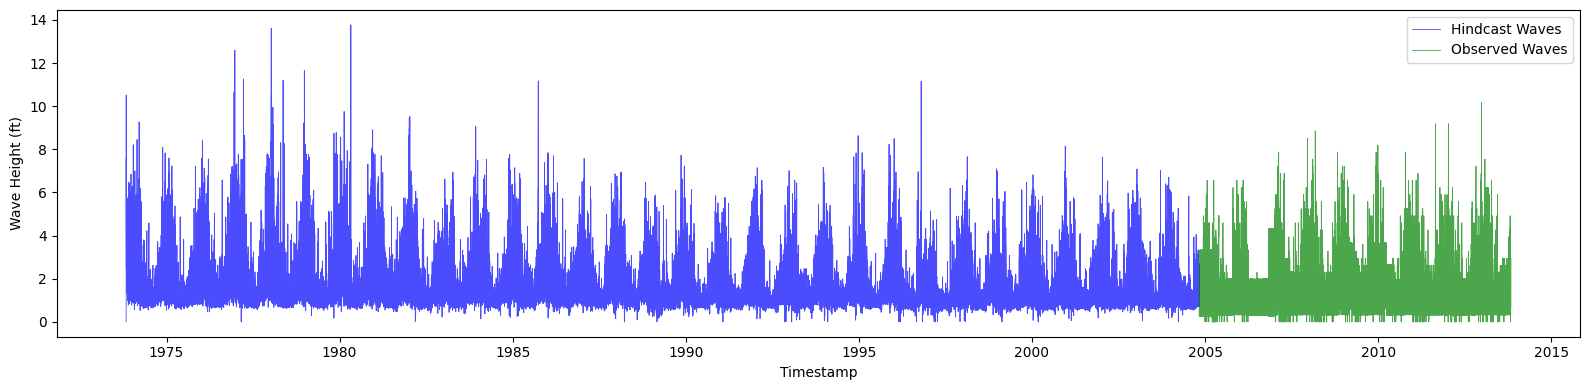

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(df2.index, df2['H_pred'], linewidth=0.6, color='b', alpha=0.7, label='Hindcast Waves')
plt.plot(df1.index, df1['H'], linewidth=0.6, color='g', alpha=0.7, label='Observed Waves')

plt.xlabel('Timestamp')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()

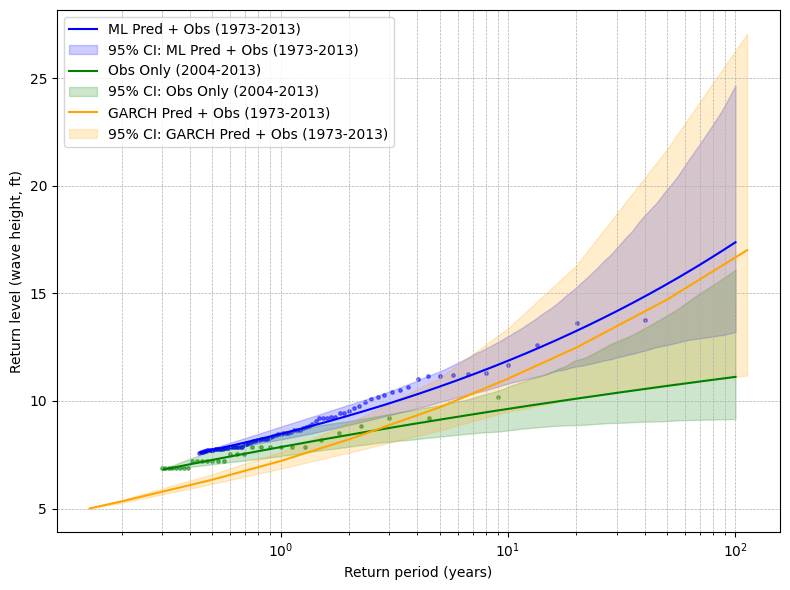

In [4]:
def return_level_plot(num, thresh, max_pred, max_obs, ax):
    if num == 1:
        SWH = pd.concat([max_pred, max_obs], axis=0)
        label = 'ML Pred + Obs (1973-2013)'
        color = 'b'
    elif num == 2:
        SWH = max_obs
        label = 'Obs Only (2004-2013)'
        color = 'g'

    # Fit GPD to exceedances
    exceed = SWH[SWH > thresh] - thresh
    xi, _, sigma = stats.genpareto.fit(exceed, floc=0)

    # Return periods (in days) and return levels
    exceed_rate = len(exceed) / len(SWH)
    return_periods = np.logspace(np.log10(0.01), np.log10(100), 300) * 365
    return_levels = thresh + (sigma / xi) * ((return_periods * exceed_rate) ** xi - 1)

    # Bootstrap confidence intervals
    n_bootstrap = 1000
    bootstrap_levels = np.zeros((n_bootstrap, len(return_periods)))

    for i in range(n_bootstrap):
        resampled = np.random.choice(exceed, size=len(exceed), replace=True)
        xi_b, _, sigma_b = stats.genpareto.fit(resampled, floc=0)
        try:
            rl_b = thresh + (sigma_b / xi_b) * ((return_periods * exceed_rate) ** xi_b - 1)
            bootstrap_levels[i, :] = rl_b
        except:
            bootstrap_levels[i, :] = np.nan

    lower_bound = np.percentile(bootstrap_levels, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_levels, 97.5, axis=0)

    # Return level plot
    mask1 = return_levels > thresh
    ax.plot(return_periods[mask1] / 365, return_levels[mask1], color=color, label=label)
    ax.fill_between(return_periods[mask1] / 365, lower_bound[mask1], upper_bound[mask1], color=color, alpha=0.2, label=f'95% CI: {label}')

    # Add empirical points
    sorted_SWH = np.sort(SWH.dropna())[::-1]
    emp_return_periods = (len(sorted_SWH) + 1) / np.arange(1, len(sorted_SWH) + 1)
    mask2 = sorted_SWH > thresh
    ax.scatter(emp_return_periods[mask2] / 365, sorted_SWH[mask2], color=color, s=6, alpha=0.5)

# Determine function parameters
fig, ax = plt.subplots(figsize=(8, 6))
return_level_plot(1, 7.6, max_pred, max_obs, ax)
return_level_plot(2, 6.8, max_pred, max_obs, ax)

# Add return level plot of GARCH model
df = pd.read_csv('return_level_plot.csv')
label = 'GARCH Pred + Obs (1973-2013)'
ax.plot(df['X'], df['Y'], color='orange', label=label)
ax.fill_between(df['X'], df['Y1'], df['Y2'], color='orange', alpha=0.2, label=f'95% CI: {label}')

ax.set_xscale('log')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Return level (wave height, ft)')
ax.grid(True, which="both", ls="--", lw=0.5)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('return_level_plot.png', dpi=1200, format='png')
plt.show()